In [261]:
import pandas as pd

In [262]:
data = pd.read_csv('predictors.csv')

In [263]:
data.drop(columns=['id', 'timestamp'], inplace=True)

In [264]:
X = data[['air_humidity', 'temperature', 'pm2_5', 'wind_speed']]
y = data['soil_moisture']

### Explore a bit na

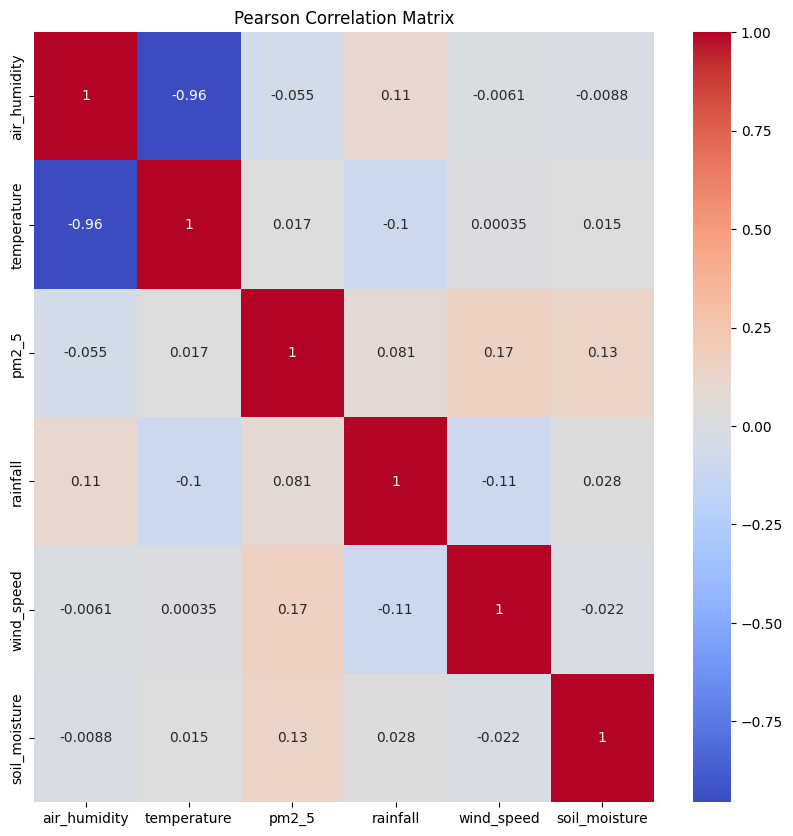

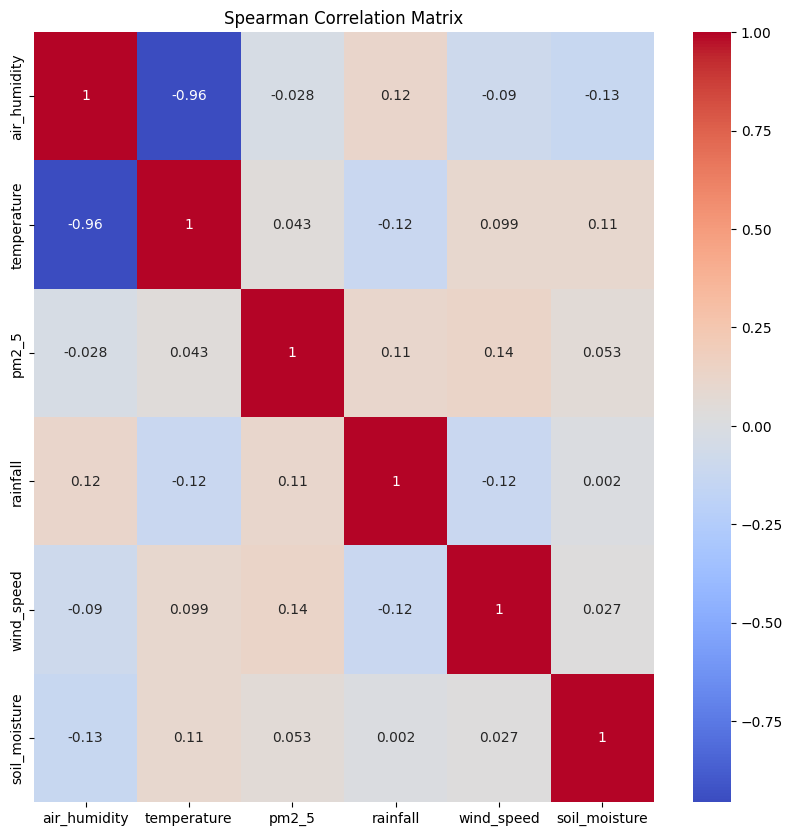

In [265]:
# Plot correlation matrix, both pearson and spearman

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()

plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix')
plt.show()

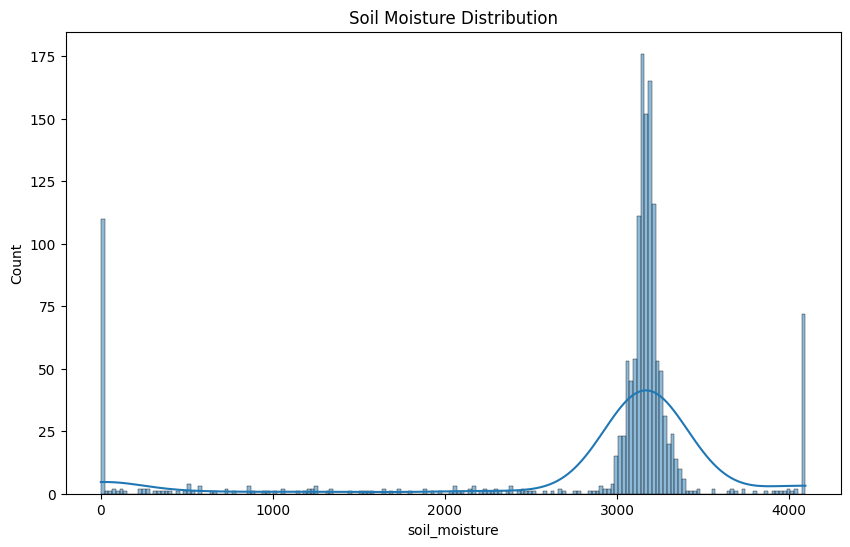

In [266]:
plt.figure(figsize=(10, 6))
sns.histplot(data['soil_moisture'], kde=True)
plt.title('Soil Moisture Distribution')
plt.show()

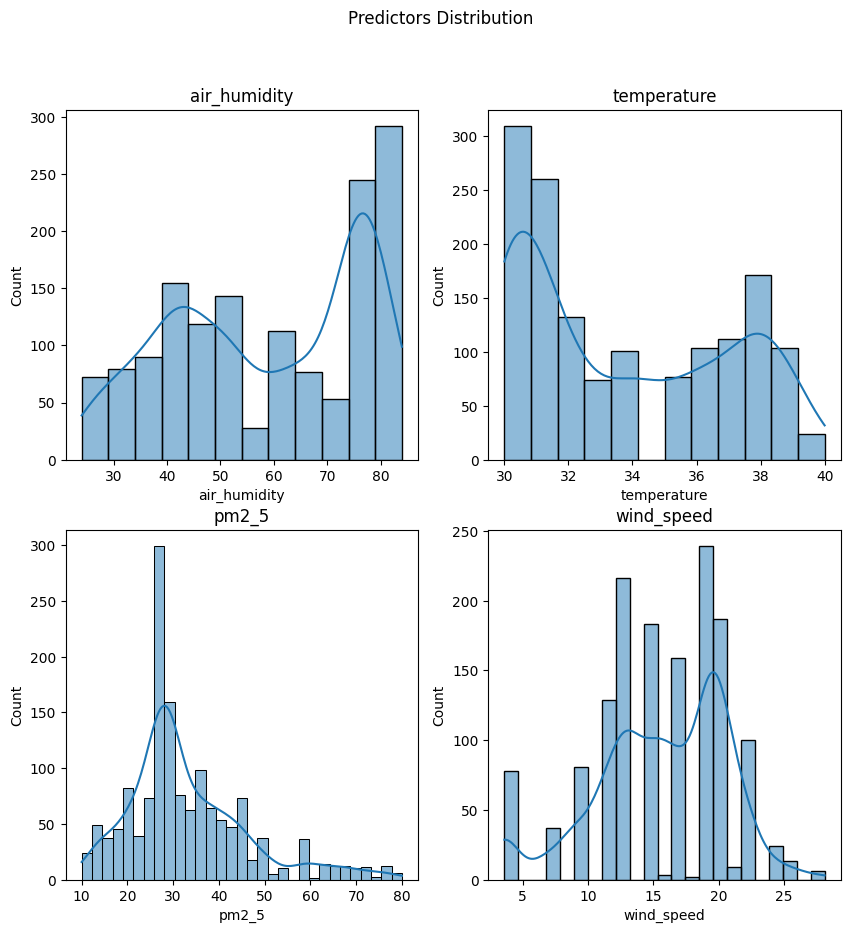

In [267]:
plt.figure(figsize=(10, 10))
for i, col in enumerate(X.columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(X[col], kde=True)
    plt.title(col)
plt.suptitle('Predictors Distribution')
plt.show()

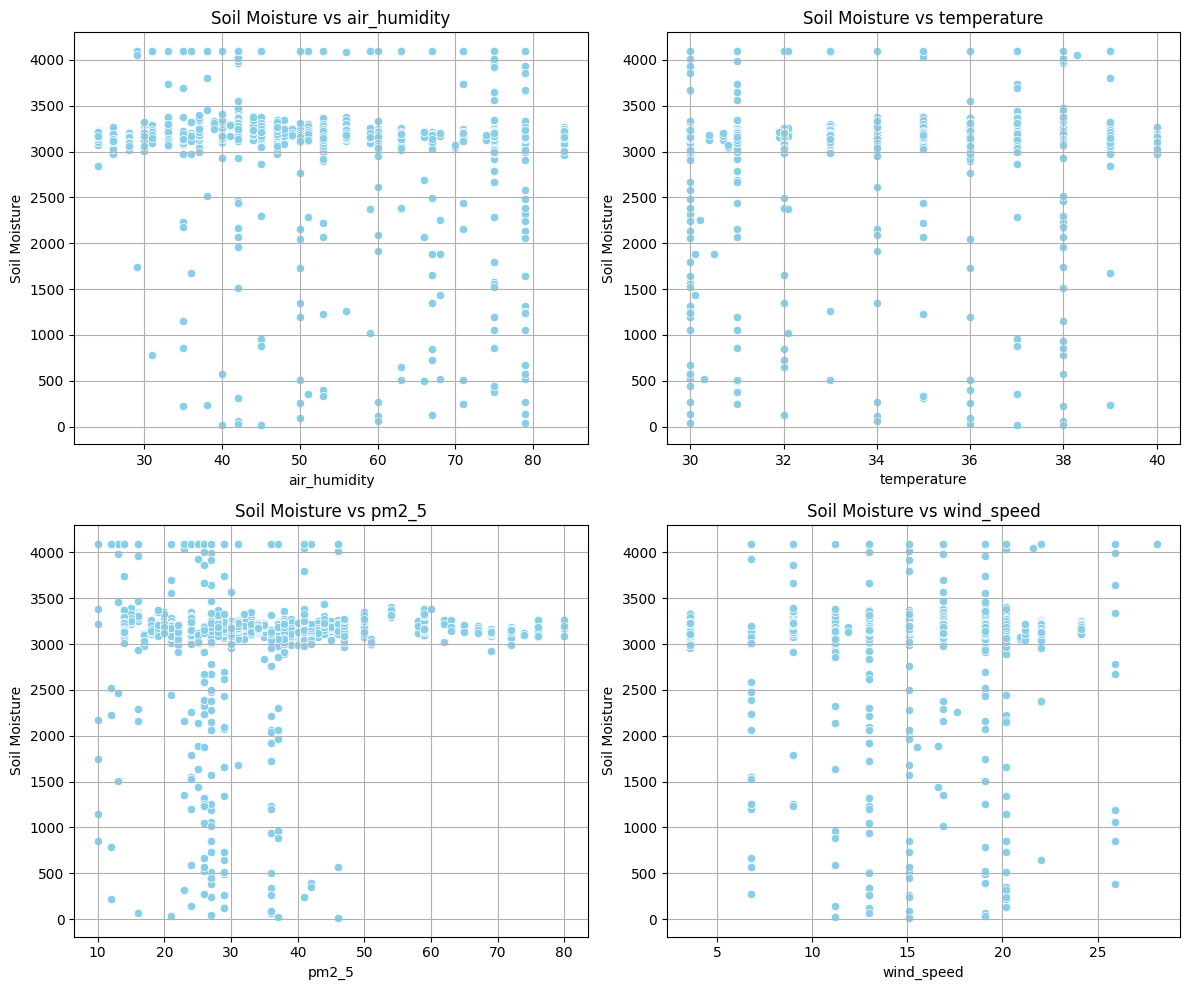

In [302]:
plt.figure(figsize=(12, 10))

for i, col in enumerate(X.columns):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=X[col], y=y, marker='o', color='skyblue')
    plt.xlabel(col)
    plt.ylabel('Soil Moisture')
    plt.title(f'Soil Moisture vs {col}')
    plt.grid(True)

plt.tight_layout()
plt.show()

### Preprocess

In [268]:
# def transform_adc_to_resistance(adc_value):
#     if adc_value == 0:
#         return 0
#     V_A = (adc_value / 4095.0) * 1.1
#     Rs = (2626000 - 1010000 * V_A - 100 * V_A) / V_A
#     return Rs

# y = y.apply(transform_adc_to_resistance)

In [269]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [270]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [271]:
data_no_zero = data[data['soil_moisture'] != 0]

No zero

In [272]:
X = data_no_zero[['air_humidity', 'temperature', 'pm2_5', 'wind_speed']]
y = data_no_zero['soil_moisture']

In [273]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled_2 = scaler.fit_transform(X_train_2)
X_test_scaled_2 = scaler.transform(X_test_2)

No outlier

In [304]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

data_no_outlier = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]

In [308]:
X = data_no_outlier[['air_humidity', 'temperature', 'pm2_5', 'wind_speed']]
y = data_no_outlier['soil_moisture']

In [313]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled_3 = scaler.fit_transform(X_train_3)
X_test_scaled_3 = scaler.transform(X_test_3)

### Train

#### Utils

In [274]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate_result(test_set, prediction):
    mse = mean_squared_error(test_set, prediction)
    rmse = mean_squared_error(test_set, prediction, squared=False)
    mae = mean_absolute_error(test_set, prediction)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)

def plot_predict_vs_actual(test_set, prediction):
    plt.figure(figsize=(10, 6))
    plt.plot(test_set, test_set, color='red', linestyle='--', label='Ideal Line (Actual = Predicted)')
    plt.scatter(test_set, prediction, label='Predictions', alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Train Process

#### Contain-0 target

In [275]:
from sklearn.linear_model import ElasticNet, LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [276]:
linear_regression = LinearRegression()
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
xgb_regressor = XGBRegressor(reg_alpha=0.1, reg_lambda=0.1)
random_forest_regressor = RandomForestRegressor(max_depth=10)
svr = SVR()

In [311]:
def fit_model(x_train, y_train):
    global linear_regression, elastic_net, xgb_regressor, random_forest_regressor, svr
    linear_regression.fit(x_train, y_train)
    elastic_net.fit(x_train, y_train)
    xgb_regressor.fit(x_train, y_train)
    random_forest_regressor.fit(x_train, y_train)
    svr.fit(x_train, y_train)

In [277]:
fit_model(X_train_scaled, y_train)

SVR()

In [278]:
models_name = ['Linear Regression', 'Elastic Net', 'XGBoost', 'Random Forest', 'SVR']
for i in range(5):
    print("results for", models_name[i])
    pred = [linear_regression, elastic_net, xgb_regressor, random_forest_regressor, svr][i].predict(X_test_scaled)
    evaluate_result(y_test, pred)
    print()

results for Linear Regression
Mean Squared Error: 829480.1866692426
Root Mean Squared Error: 910.7580286054264
Mean Absolute Error: 603.7314720385831

results for Elastic Net
Mean Squared Error: 831589.1679993403
Root Mean Squared Error: 911.9151100839049
Mean Absolute Error: 604.668636938782

results for XGBoost
Mean Squared Error: 1008203.3623228507
Root Mean Squared Error: 1004.0933035942679
Mean Absolute Error: 436.2515265291848

results for Random Forest
Mean Squared Error: 850547.2508637721
Root Mean Squared Error: 922.2511864257872
Mean Absolute Error: 428.1137199126497

results for SVR
Mean Squared Error: 905161.8404467639
Root Mean Squared Error: 951.399937169834
Mean Absolute Error: 418.63278191310735



results for Linear Regression


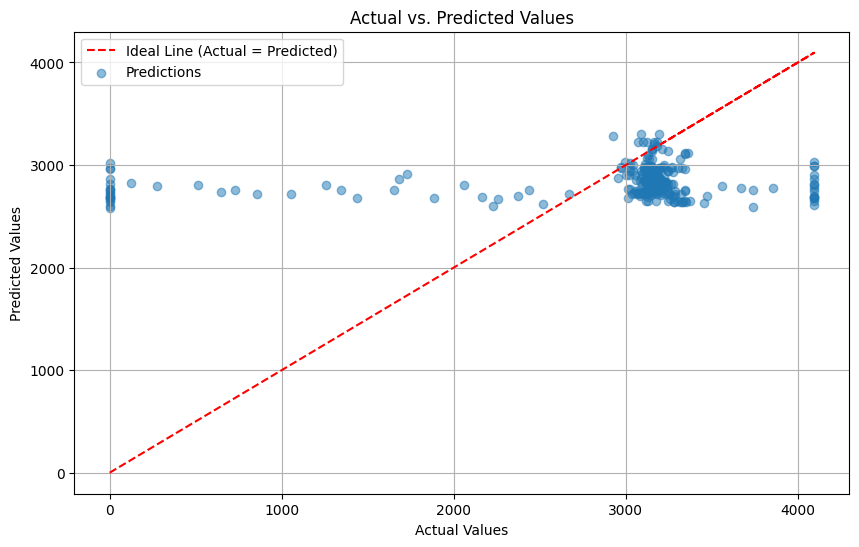

results for Elastic Net


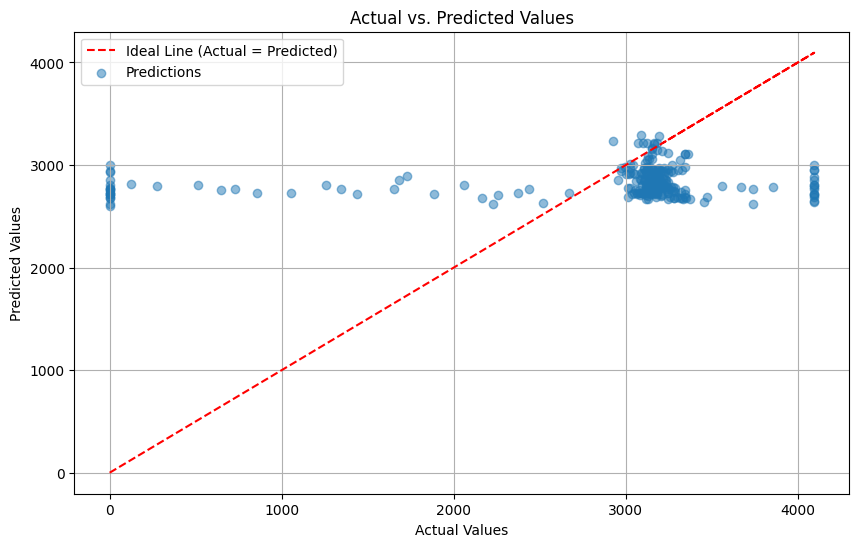

results for XGBoost


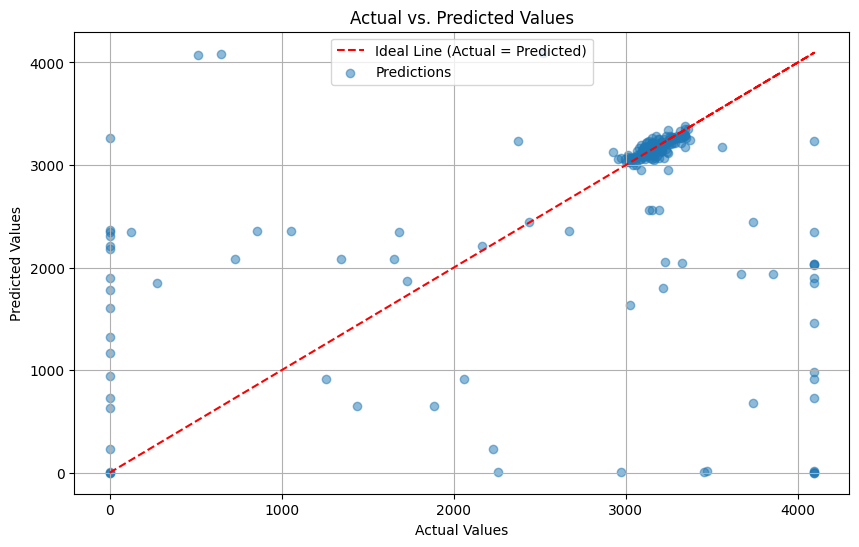

results for Random Forest


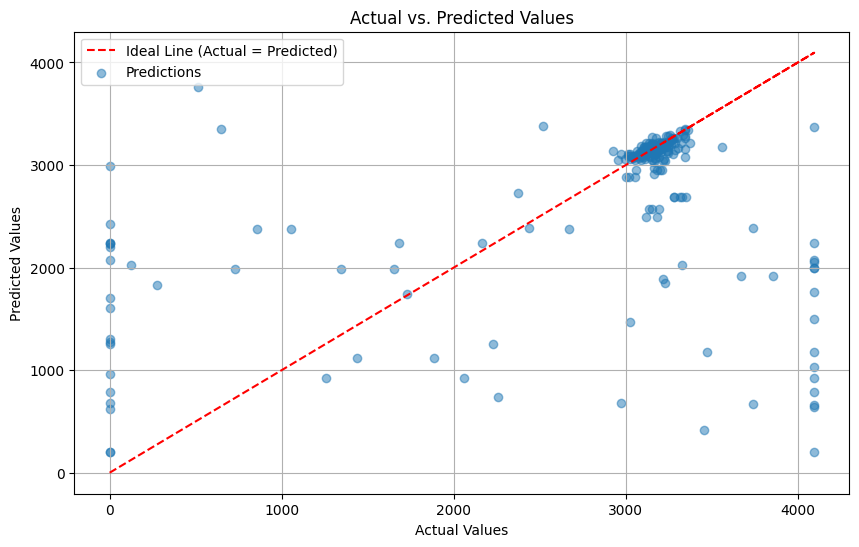

results for SVR


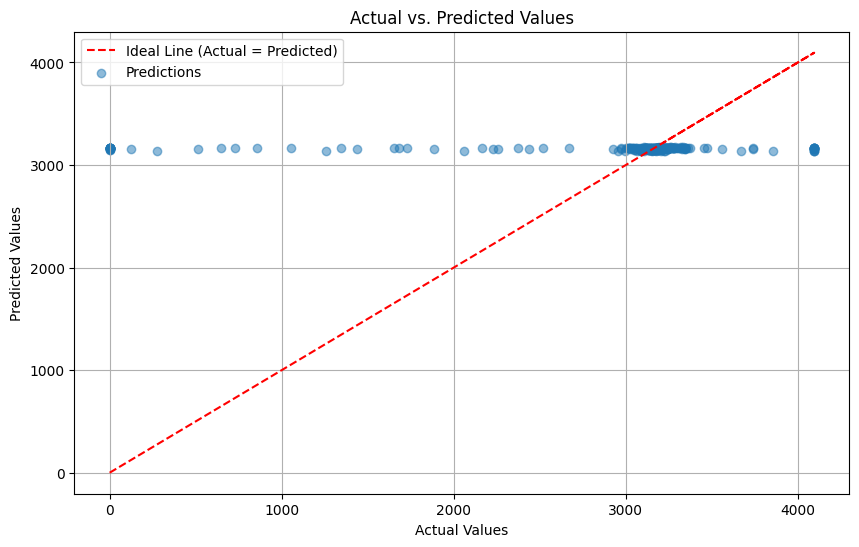

In [279]:
for i in range(5):
    print("results for", models_name[i])
    pred = [linear_regression, elastic_net, xgb_regressor, random_forest_regressor, svr][i].predict(X_test_scaled)
    plot_predict_vs_actual(y_test, pred)

#### No-0 target

In [282]:
linear_regression.fit(X_train_scaled_2, y_train_2)
elastic_net.fit(X_train_scaled_2, y_train_2)
xgb_regressor.fit(X_train_scaled_2, y_train_2)
random_forest_regressor.fit(X_train_scaled_2, y_train_2)
svr.fit(X_train_scaled_2, y_train_2)

SVR()

In [283]:
models_name = ['Linear Regression', 'Elastic Net', 'XGBoost', 'Random Forest', 'SVR']
for i in range(5):
    print("results for", models_name[i])
    pred = [linear_regression, elastic_net, xgb_regressor, random_forest_regressor, svr][i].predict(X_test_scaled_2)
    evaluate_result(y_test_2, pred)
    print()

results for Linear Regression
Mean Squared Error: 290545.87984970165
Root Mean Squared Error: 539.0230791438356
Mean Absolute Error: 256.94639652343517

results for Elastic Net
Mean Squared Error: 290404.6408897686
Root Mean Squared Error: 538.8920493844464
Mean Absolute Error: 256.53997020271873

results for XGBoost
Mean Squared Error: 353111.95623386605
Root Mean Squared Error: 594.2322409915723
Mean Absolute Error: 216.88834964527803

results for Random Forest
Mean Squared Error: 291669.5569675292
Root Mean Squared Error: 540.0644007593254
Mean Absolute Error: 201.90311293678786

results for SVR
Mean Squared Error: 291112.2029503648
Root Mean Squared Error: 539.5481470178215
Mean Absolute Error: 214.72635442123732



results for Linear Regression


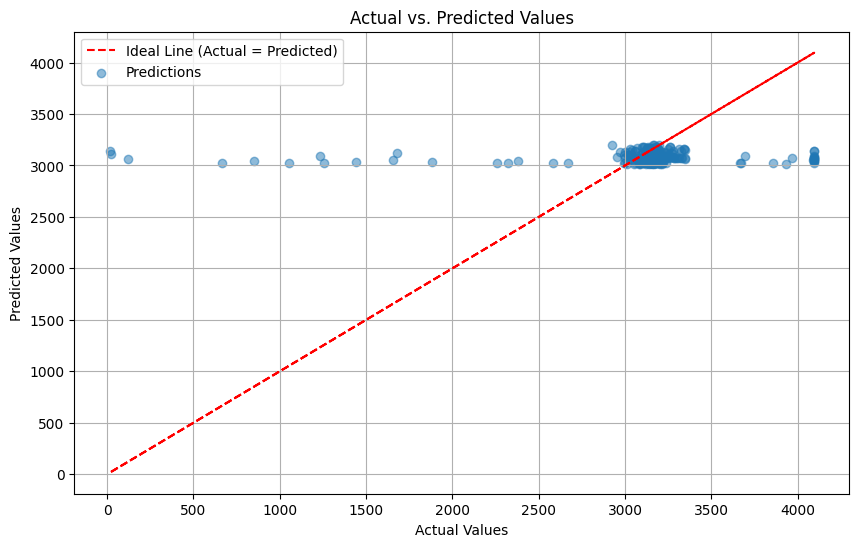

results for Elastic Net


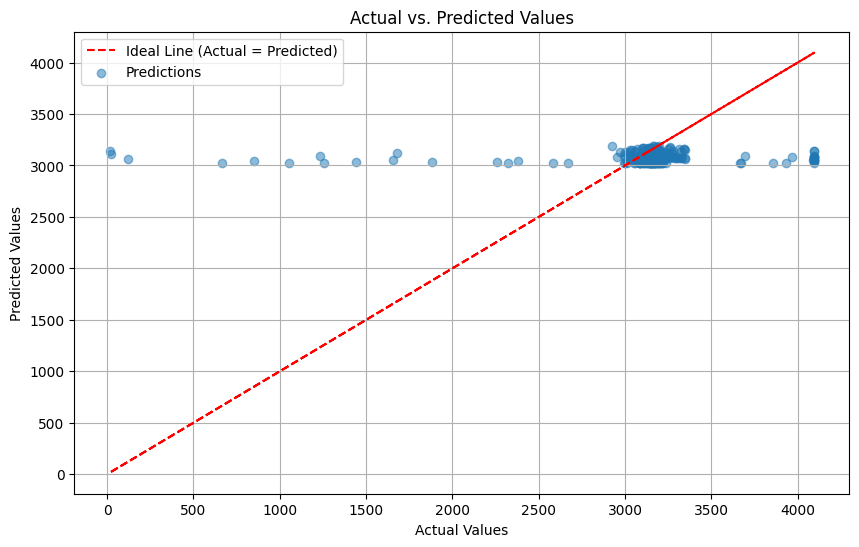

results for XGBoost


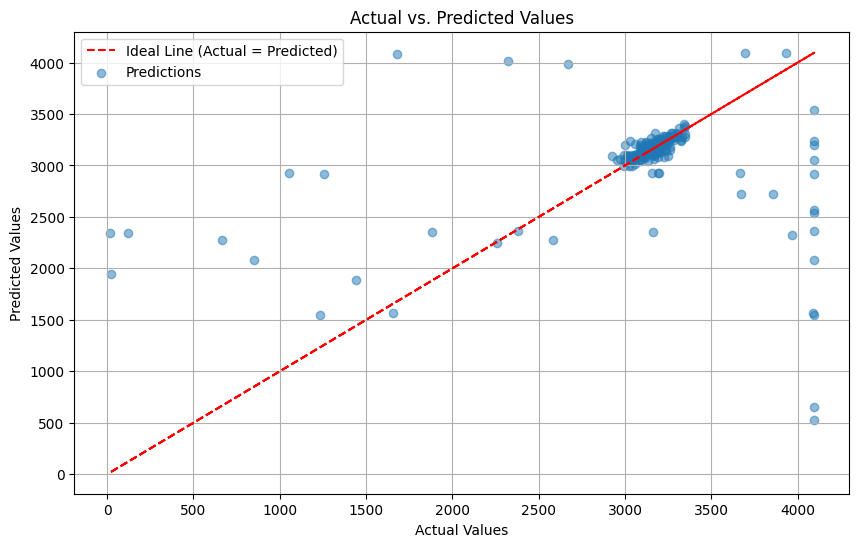

results for Random Forest


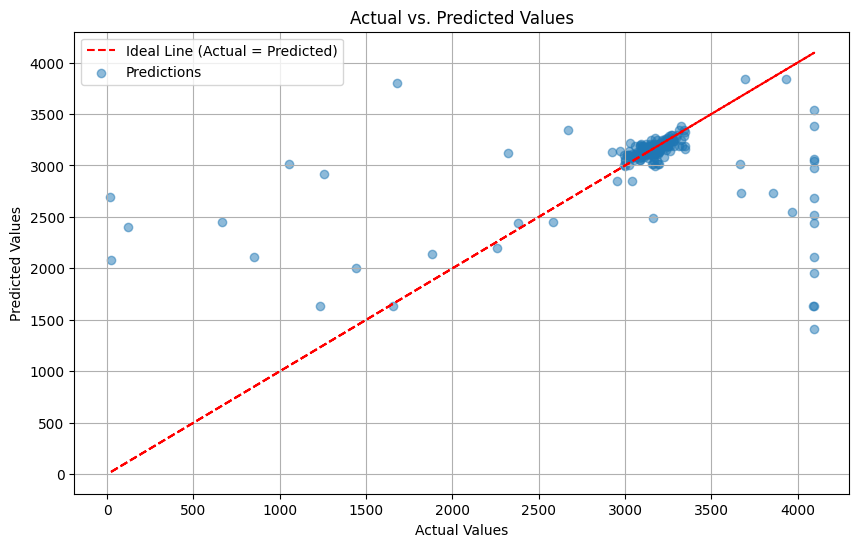

results for SVR


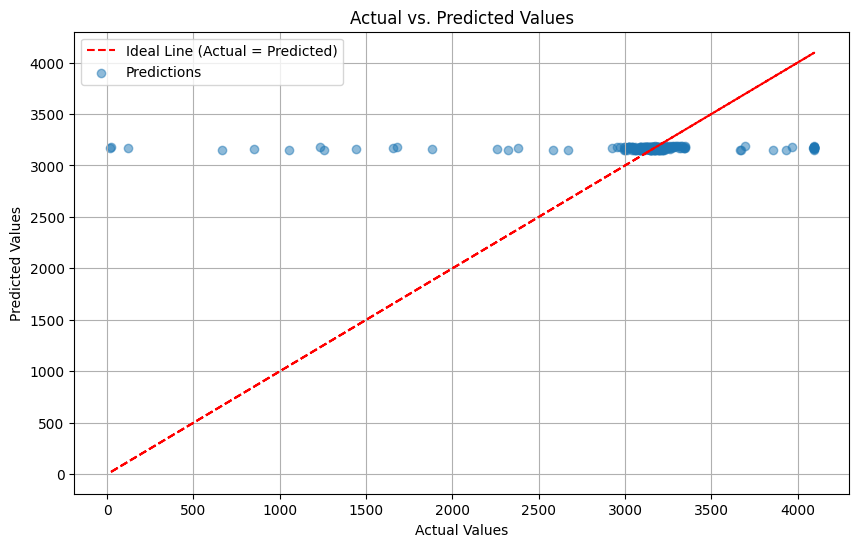

In [285]:
for i in range(5):
    print("results for", models_name[i])
    pred = [linear_regression, elastic_net, xgb_regressor, random_forest_regressor, svr][i].predict(X_test_scaled_2)
    plot_predict_vs_actual(y_test_2, pred)

### Try bootstraping

In [287]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    }

    model = RandomForestRegressor(**params)
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_score = -study.best_value

print(f'Best Hyperparameters: {best_params}')

[I 2024-05-06 19:36:20,266] A new study created in memory with name: no-name-dc867467-e01d-4acf-bf06-c86c023b335c
[I 2024-05-06 19:36:21,308] Trial 0 finished with value: 431656.1961369946 and parameters: {'n_estimators': 158, 'max_depth': 6, 'min_samples_leaf': 5}. Best is trial 0 with value: 431656.1961369946.
[I 2024-05-06 19:36:22,323] Trial 1 finished with value: 451100.9003913441 and parameters: {'n_estimators': 132, 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 431656.1961369946.
[I 2024-05-06 19:36:23,793] Trial 2 finished with value: 425640.6864759723 and parameters: {'n_estimators': 231, 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 2 with value: 425640.6864759723.
[I 2024-05-06 19:36:26,718] Trial 3 finished with value: 445302.0718903523 and parameters: {'n_estimators': 369, 'max_depth': 12, 'min_samples_leaf': 5}. Best is trial 2 with value: 425640.6864759723.
[I 2024-05-06 19:36:35,440] Trial 4 finished with value: 472020.8681491511 and parame

Best Hyperparameters: {'n_estimators': 168, 'max_depth': 5, 'min_samples_leaf': 2}


In [288]:
from sklearn.utils import resample

n_iterations = 1000
n_size = int(len(X_train_scaled_2) * 0.5)

models = []

for i in range(n_iterations):
    X_sample, y_sample = resample(X_train_scaled_2, y_train_2, n_samples=n_size)
    model = RandomForestRegressor(**best_params)
    model.fit(X_sample, y_sample)
    models.append(model)

y_preds = []

for model in models:
    y_pred = model.predict(X_test_scaled_2)
    y_preds.append(y_pred)

y_pred = sum(y_preds) / n_iterations

In [289]:
evaluate_result(y_test_2, y_pred)

Mean Squared Error: 263870.35529000947
Root Mean Squared Error: 513.6831273168406
Mean Absolute Error: 226.96879484867728


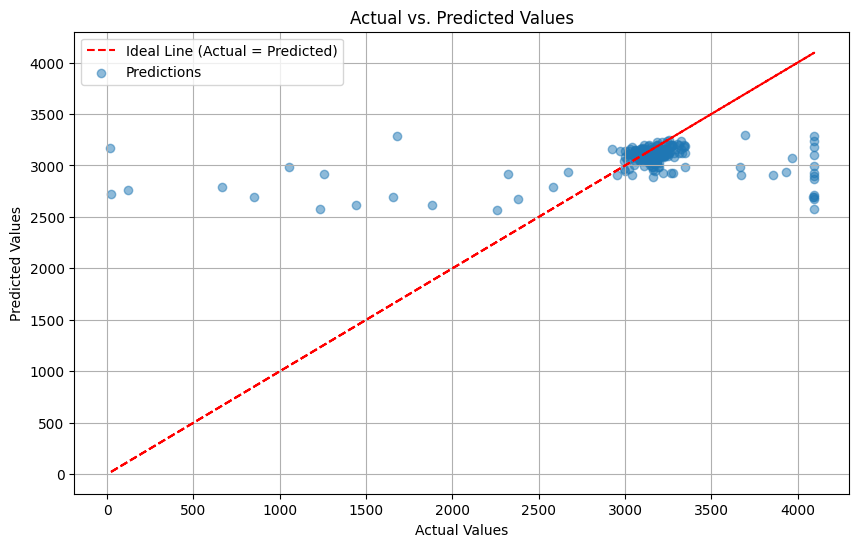

In [290]:
plot_predict_vs_actual(y_test_2, y_pred)

### No outlier

In [338]:
fit_model(X_train_scaled_3, y_train_3)

models_name = ['Linear Regression', 'Elastic Net', 'XGBoost', 'Random Forest', 'SVR']
for i in range(5):
    print("results for", models_name[i])
    pred = [linear_regression, elastic_net, xgb_regressor, random_forest_regressor, svr][i].predict(X_test_scaled_3)
    evaluate_result(y_test_3, pred)
    print()

results for Linear Regression
Mean Squared Error: 5552.411319179079
Root Mean Squared Error: 74.51450408597698
Mean Absolute Error: 57.16183126208438

results for Elastic Net
Mean Squared Error: 5637.136622543026
Root Mean Squared Error: 75.0808672202381
Mean Absolute Error: 57.42337687929955

results for XGBoost
Mean Squared Error: 4051.671650634147
Root Mean Squared Error: 63.65274267959038
Mean Absolute Error: 43.193007151285805

results for Random Forest
Mean Squared Error: 3456.9607726538393
Root Mean Squared Error: 58.79592479631424
Mean Absolute Error: 41.440632085912576

results for SVR
Mean Squared Error: 5545.505668318657
Root Mean Squared Error: 74.46815204044381
Mean Absolute Error: 56.8285038268036



results for Linear Regression


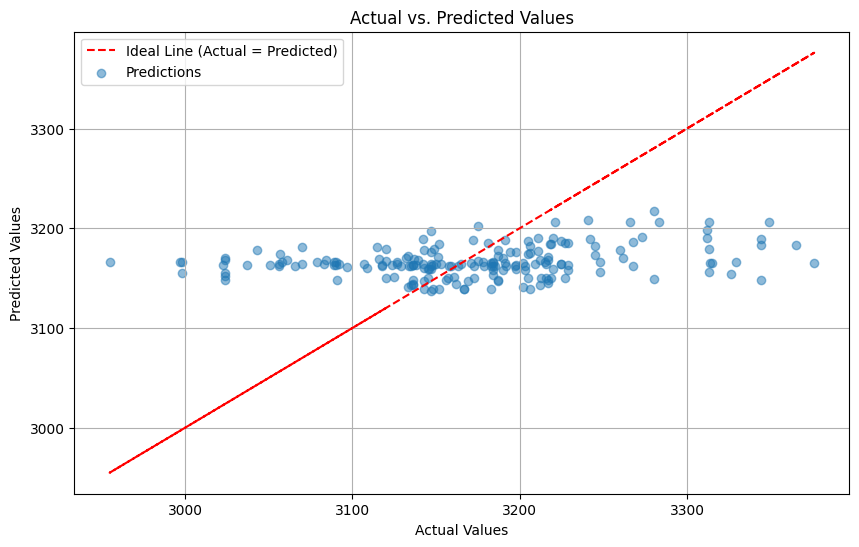

results for Elastic Net


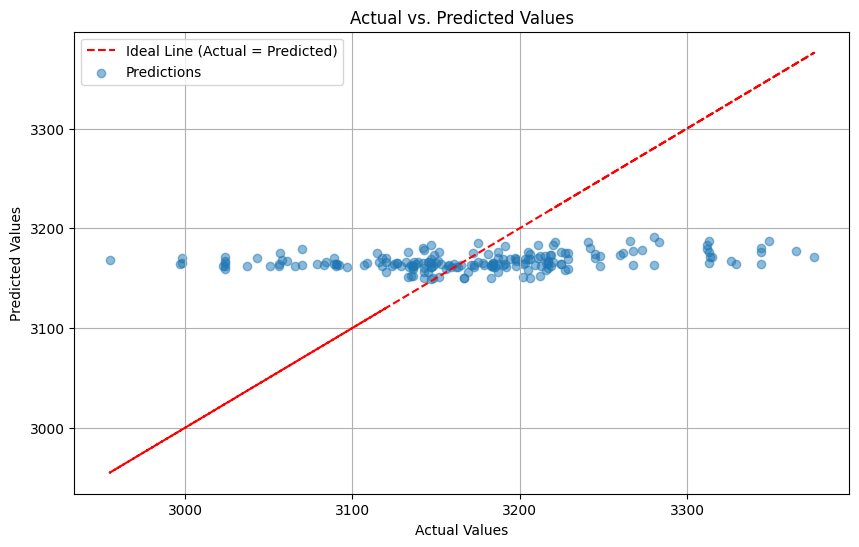

results for XGBoost


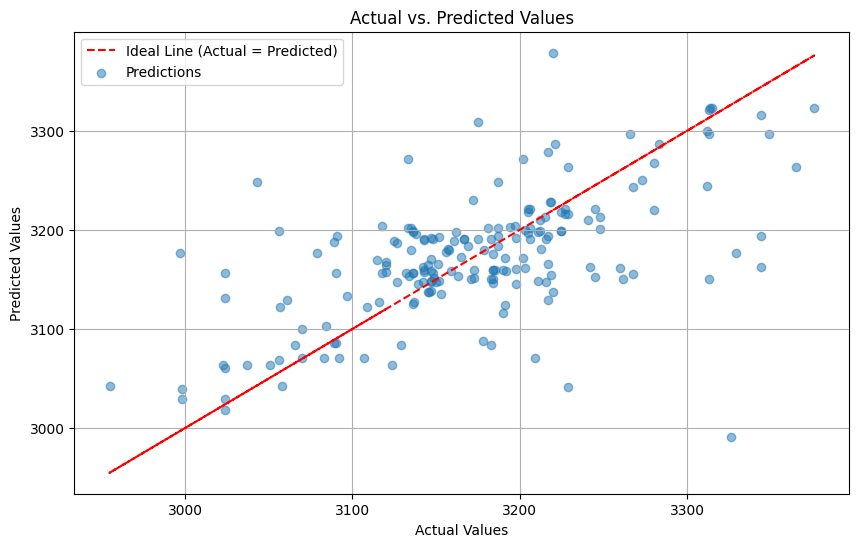

results for Random Forest


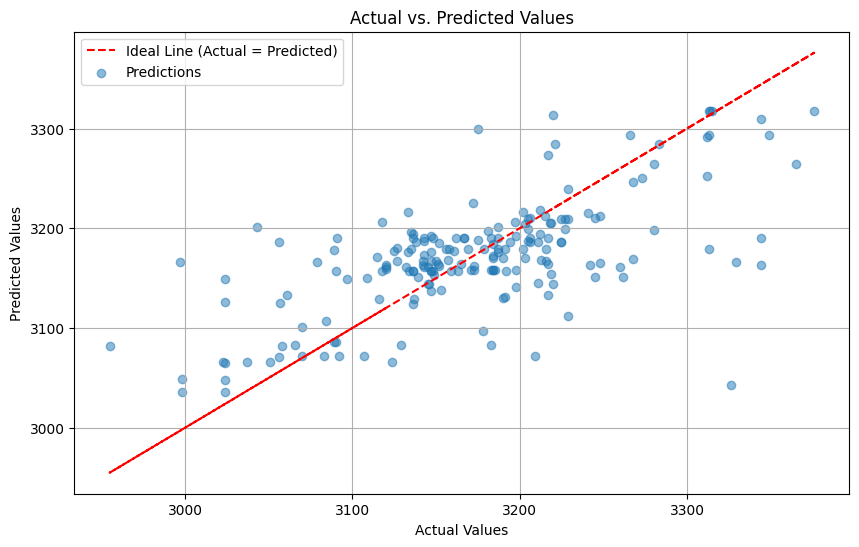

results for SVR


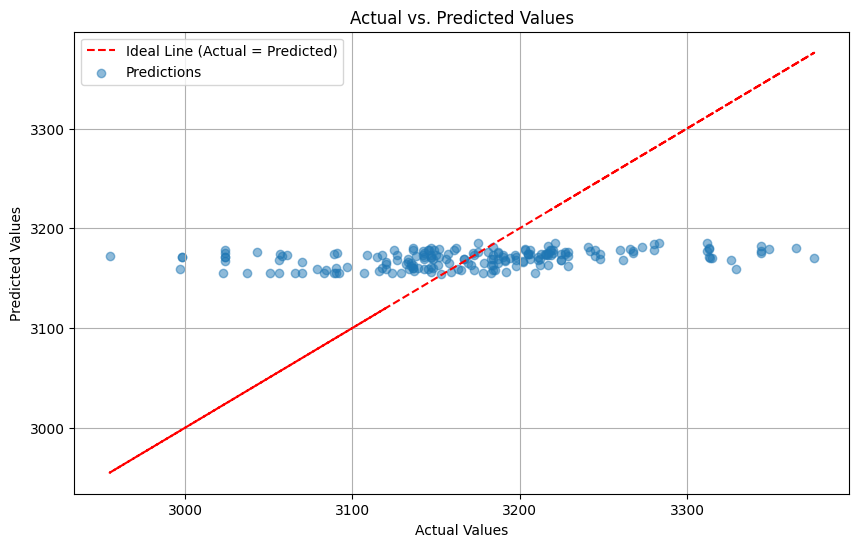

In [315]:
for i in range(5):
    print("results for", models_name[i])
    pred = [linear_regression, elastic_net, xgb_regressor, random_forest_regressor, svr][i].predict(X_test_scaled_3)
    plot_predict_vs_actual(y_test_3, pred)

In [333]:
from sklearn.utils import resample

n_iterations = 100
n_size = int(len(X_train_scaled_3) * 0.5)

models = []

for i in range(n_iterations):
    X_sample, y_sample = resample(X_train_scaled_3, y_train_3, n_samples=n_size)
    model = RandomForestRegressor(**best_params)
    model.fit(X_sample, y_sample)
    models.append(model)

y_preds = []

for model in models:
    y_pred = model.predict(X_test_scaled_3)
    y_preds.append(y_pred)

y_pred = sum(y_preds) / n_iterations

In [334]:
evaluate_result(y_test_3, y_pred)

Mean Squared Error: 3968.51235803608
Root Mean Squared Error: 62.99612970680088
Mean Absolute Error: 47.92327313227174


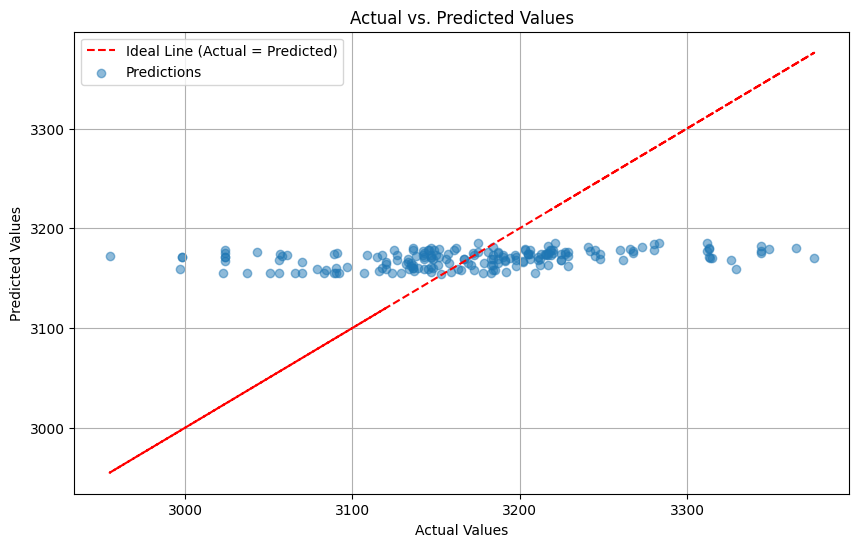

In [335]:
plot_predict_vs_actual(y_test_3, pred)

maybe overfit

### Try xgboost + Random Forest prediction

Mean Squared Error: 3767.8162297701965
Root Mean Squared Error: 61.38254010523022
Mean Absolute Error: 46.43354432379929


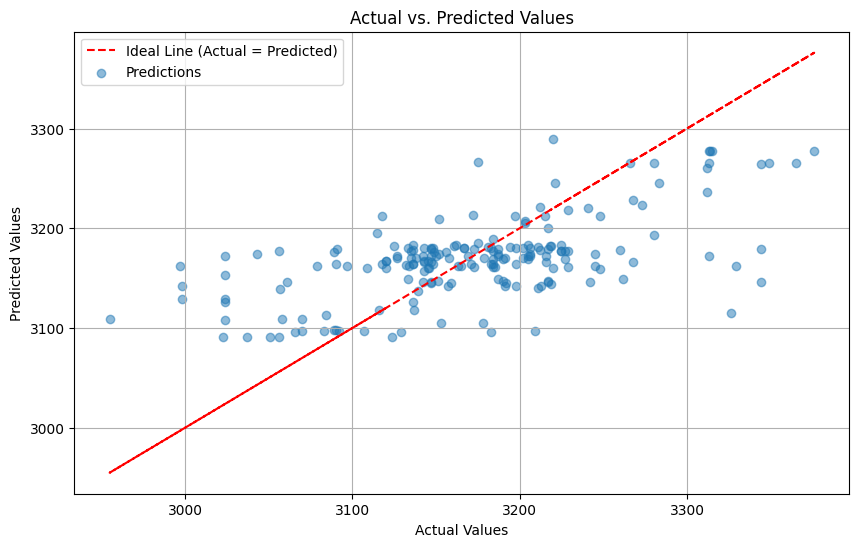

In [340]:
rf_model = RandomForestRegressor(**best_params)
rf_model.fit(X_train_scaled_3, y_train_3)

xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled_3, y_train_3)

rf_pred = rf_model.predict(X_test_scaled_3)
xgb_pred = xgb_model.predict(X_test_scaled_3)

ensemble_pred = (rf_pred + xgb_pred) / 2

evaluate_result(y_test_3, ensemble_pred)
plot_predict_vs_actual(y_test_3, ensemble_pred)

# Save model

In [341]:
import joblib

joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(xgb_model, 'xgb_model.pkl')

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# loaded_rf_model = joblib.load('rf_model.pkl')
# loaded_xgb_model = joblib.load('xgb_model.pkl')

# rf_pred_loaded = loaded_rf_model.predict(X_test_scaled_3)
# xgb_pred_loaded = loaded_xgb_model.predict(X_test_scaled_3)
# ensemble_pred_loaded = (rf_pred_loaded + xgb_pred_loaded) / 2

['xgb_model.pkl']